In [1]:
import requests
from datetime import datetime
import time
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
sr = pd.read_csv('https://github.com/jdfoote/Intro-to-Programming-and-Data-Science/blob/fall2021/resources/data/sr_post_data.csv?raw=true')
sr['all_text'] = sr['title'] + ' ' + sr['selftext']

In [9]:
# Change the date to a datetime, and put it in the index
sr.index = pd.to_datetime(sr.date)

### EXERCISE 1

Modify the code above to plot how often "Coronavirus" is used in each of the three subreddits over time

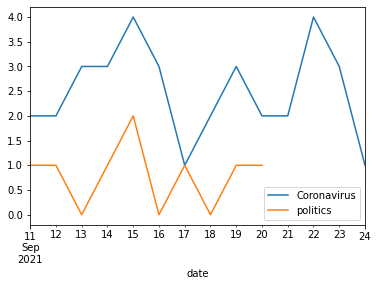

In [10]:
for subreddit in sr.subreddit.unique():
    term = 'coronavirus'
    curr_df = sr.loc[sr.subreddit == subreddit]
    curr_df = curr_df.loc[curr_df.title.str.contains(term) | curr_df.selftext.str.contains(term)]
    if len(curr_df) > 0:
        posts_per_day = curr_df.resample('D').size()
        posts_per_day.plot(label = subreddit)

plt.legend()
plt.show()

### EXERCISE 2

One of the trickiest parts of analysis is getting the data in the form that you want it in order to analyze/visualize it. 

I think a good visualization for this would be a barplot showing how often male and female word types appear for each subreddit. I'll give you the final call to produce the plot:

`sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df_long)`

Now, see if you can get the data in shape so that this code actually works! :)

*Hint: You'll want to use [wide to long](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html)*

In [11]:
def get_words_ratio(strings):
    result = {}
    for name, group in sr.groupby('subreddit').all_text:
        result[name] = {'matches':0, 'all_words': 0}
        for s in group:
            text_list = s.split()
            for string in strings:
                result[name]['matches'] += text_list.count(string)
            result[name]['all_words'] += len(text_list)
    final_result = {}
    for name, values in result.items():
        final_result[name] = values['matches'] / values['all_words']
    return final_result
        

In [13]:
sr.loc[(pd.isna(sr.selftext)) | (sr.selftext.isin(['[removed]', '[deleted]'])), 'selftext'] = ''
sr['all_text'] = sr.title + ' ' + sr.selftext

male_words = ['he', 'his']
female_words = ['she', 'hers']

# This puts all of the text of each subreddit into lists
def string_to_list(x):
   # print(' '.join(x))
    return ' '.join(x).split()
grouped_text = sr.groupby('subreddit').all_text.apply(string_to_list)

# Then, we count how often each type of words appears in each subreddit
agg = grouped_text.aggregate({'proportionMale': lambda x: sum([x.count(y) for y in male_words])/len(x),
                        'proportionFemale': lambda x: sum([x.count(y) for y in female_words])/len(x)}
                        )

In [14]:
agg_df = agg.unstack(level=0)
agg_df = agg_df.reset_index()

In [15]:
agg_df

subreddit  proportionMale  proportionFemale
0  Coronavirus        0.001874          0.000234
1          aww        0.011129          0.003251
2     politics        0.003950          0.000525

In [24]:
df_pivoted = agg.pivot(index='subreddit', columns='word_gender', values='proportion').reset_index()

# Rename the columns
df_pivoted.columns = ['subreddit', 'female', 'male']

# Fill NaN values with 0 if needed
df_pivoted.fillna(0, inplace=True)

# Print the resulting DataFrame
print(df_pivoted)

AttributeError: 'Series' object has no attribute 'pivot'

In [16]:
pd.melt(agg_df, 
                      id_vars='subreddit',
                      value_vars=['proportionFemale','proportionMale'],
                      var_name='word_gender',
                      value_name='proportion'
                     )

subreddit       word_gender  proportion
0  Coronavirus  proportionFemale    0.000234
1          aww  proportionFemale    0.003251
2     politics  proportionFemale    0.000525
3  Coronavirus    proportionMale    0.001874
4          aww    proportionMale    0.011129
5     politics    proportionMale    0.003950

In [21]:
agg_df_long = pd.wide_to_long(agg_df, # The data
                # The prefixes for the data columns. These will become column names that hold data values.
                stubnames = 'proportion', 
                # i is a column which uniquely identifies each row
                i='subreddit',
                # j is what you want to call the new column that describes the values
                j='word_gender',
                # sep is a string that is between the stubnames and the values which will go in j
                sep='',
                suffix = '\w+'
               )


In [ ]:

agg_df_long = agg_df_long.reset_index()

In [25]:
agg_df_long

subreddit word_gender  proportion
0  Coronavirus        Male    0.001874
1          aww        Male    0.011129
2     politics        Male    0.003950
3  Coronavirus      Female    0.000234
4          aww      Female    0.003251
5     politics      Female    0.000525

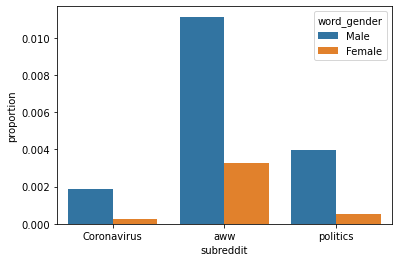

In [27]:
sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df_long);

### EXERCISE 3

Make your own analysis, with a different set of terms

Goal: Compare how often risk-based terms appear across subreddits

### EXERCISE 4

Where topic modeling really shines is in analyzing longer texts - for example, the subreddit [changemyview](https://www.reddit.com/r/changemyview/) has fairly long posts where people explain a controversial view that they hold.

Try to figure out how to get a few hundred posts from changemyview, and run a topic model on them, where the selftext of each post is a document.

In [3]:
## Code used to create the dataset - no need to run this code
import praw
import reddit_authentication

reddit = praw.Reddit(client_id=reddit_authentication.client_id,
                        client_secret=reddit_authentication.client_secret,
                        user_agent=reddit_authentication.user_agent,
                        username=reddit_authentication.username,
                        password=reddit_authentication.password
                        )

sr_data = []
for submission in reddit.subreddit('changemyview').top(limit=1000):
    sr_data.append(f"{submission.title} {submission.selftext}")

Version 7.6.1 of praw is outdated. Version 7.7.1 was released Tuesday July 11, 2023.


In [4]:
sr_data[0]

'CMV: Mike Bloomberg\'s campaign is proof that the ultra wealthy in the US can afford a higher tax rate with no ill effect on them Mike Bloomberg recently dropped out of the 2020 Presidential race after spending over $500 million dollars of his own money on his campaign. Even with this loss, he is still worth over $55 billion dollars.\n\n\nI believe that this effortless spending on Bloombergs part showcases the reality that is wealth inequality between the ultra rich and working class. While I do not believe the rich should give up their fortunes, I do believe that any arguments against taxing them more is simply propaganda from those who hold the wealth and higher power at this point. \n\nCertain media outlets claim that taxing the super wealthy is unfair and would be detrimental to those below them due to "trickle down" effects. There is also rhetoric that many self made billionaires worked hard for their fortunes, and that if we as Americans work hard, we might be rich ourselves one

In [5]:
import gensim.parsing.preprocessing as gpp
from gensim.corpora import Dictionary
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.ldamodel import LdaModel
from pprint import pprint
from nltk.tokenize import RegexpTokenizer

def run_lda(docs, 
            n_topics, # How many topics to return
            min_count = 20 # How many docs a word must appear in to be included
           ):
    # Split the documents into tokens. This creates a list of words for each document.
    print(f"Preprocessing documents...")
    lemmatizer = WordNetLemmatizer()
    docs = [gpp.preprocess_string(x, filters=[gpp.strip_punctuation,
                                              gpp.strip_multiple_whitespaces,
                                              gpp.strip_numeric,
                                              gpp.remove_stopwords,
                                              gpp.strip_short
                                             ]) for x in docs]
    
    # Lemmatize the words

    dictionary = Dictionary(docs)
    for doc in docs:
        dictionary.add_documents([[lemmatizer.lemmatize(token) for token in doc]])
    dictionary.filter_extremes(no_below=min_count, no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    
    
    # Train LDA model
    print("Running the model...")
    # Set training parameters.
    num_topics = n_topics
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    #temp = dictionary[0]  # This is only to "load" the dictionary.
    #id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    
    return (model, corpus, dictionary, docs)
    

In [6]:
run_lda(sr_data, 10)

Preprocessing documents...
Number of unique tokens: 2191
Number of documents: 914
Running the model...


(<gensim.models.ldamodel.LdaModel at 0x7fcd8af62bb0>,
 [[(0, 1),
   (1, 1),
   (2, 1),
   (3, 1),
   (4, 1),
   (5, 2),
   (6, 2),
   (7, 1),
   (8, 4),
   (9, 1),
   (10, 1),
   (11, 2),
   (12, 3),
   (13, 1),
   (14, 1),
   (15, 1),
   (16, 1),
   (17, 1),
   (18, 1),
   (19, 2),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 1),
   (27, 2),
   (28, 1),
   (29, 3),
   (30, 1),
   (31, 1),
   (32, 1),
   (33, 1),
   (34, 1),
   (35, 1),
   (36, 1),
   (37, 1),
   (38, 2),
   (39, 1),
   (40, 1),
   (41, 1),
   (42, 1),
   (43, 1),
   (44, 1),
   (45, 1),
   (46, 1),
   (47, 1),
   (48, 1),
   (49, 1),
   (50, 1),
   (51, 1),
   (52, 1),
   (53, 3),
   (54, 1),
   (55, 1),
   (56, 2),
   (57, 1),
   (58, 1),
   (59, 1),
   (60, 1),
   (61, 1),
   (62, 2),
   (63, 2),
   (64, 1),
   (65, 1),
   (66, 1),
   (67, 1),
   (68, 2)],
  [(3, 1),
   (8, 1),
   (12, 1),
   (50, 1),
   (69, 2),
   (70, 1),
   (71, 1),
   (72, 1),
   (73, 1),
   (74, 4),
   (75, 1

In [10]:
from gensim.models.coherencemodel import CoherenceModel
coherence = []
for k in range(1,6,1):
    print(f'Running with {k} topics')
    model, corpus, dictionary, docs = run_lda(sr_data, n_topics=k)
    coherence_model = CoherenceModel(model=model, 
                               texts=docs, 
                               dictionary=dictionary, 
                               coherence='c_v')
    coherence.append((coherence_model.get_coherence(), k))
print(coherence)

Running with 1 topics
Preprocessing documents...
Number of unique tokens: 2191
Number of documents: 914
Running the model...
Running with 2 topics
Preprocessing documents...
Number of unique tokens: 2191
Number of documents: 914
Running the model...
Running with 3 topics
Preprocessing documents...
Number of unique tokens: 2191
Number of documents: 914
Running the model...
Running with 4 topics
Preprocessing documents...
Number of unique tokens: 2191
Number of documents: 914
Running the model...
Running with 5 topics
Preprocessing documents...
Number of unique tokens: 2191
Number of documents: 914
Running the model...
[(0.2801634978874887, 1), (0.3449600885935019, 2), (0.4022182727616981, 3), (0.27612369569475037, 4), (0.42017500596142954, 5)]


In [11]:
coherence

[(0.2801634978874887, 1),
 (0.3449600885935019, 2),
 (0.4022182727616981, 3),
 (0.27612369569475037, 4),
 (0.42017500596142954, 5)]